In [1]:
from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import skforecast
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Cargo Dataset principal

In [2]:
ts = pd.read_csv('../../data/ts_top100_prediction.csv')

In [3]:
ts['date']= pd.to_datetime(ts['date'], format='%Y-%m-%d')
ts['weekday'] = ts['date'].dt.day_name()
ts.head(5)

,date,id,item,sales,income,event,weekday
0,2011-01-29,ACCESORIES_1_108_NYC_1,ACCESORIES_1_108,4,64.4784,0,Saturday
1,2011-01-29,HOME_&_GARDEN_1_027_NYC_1,HOME_&_GARDEN_1_027,4,26.2000,0,Saturday
2,2011-01-29,HOME_&_GARDEN_1_053_NYC_1,HOME_&_GARDEN_1_053,0,0.0000,0,Saturday
3,2011-01-29,HOME_&_GARDEN_1_140_NYC_1,HOME_&_GARDEN_1_140,4,75.0000,0,Saturday
4,2011-01-29,HOME_&_GARDEN_1_177_NYC_1,HOME_&_GARDEN_1_177,0,0.0000,0,Saturday


In [ ]:
ts.duplicated(keep=False)

In [12]:
df_original = ts.copy()
df_filtrado = df_original[(df_original['id'] == 'SUPERMARKET_3_586_BOS_1')]

In [13]:
ts_predict = df_filtrado[['date', 'sales', 'weekday', 'event']]
ts_predict = pd.get_dummies(data=ts_predict, columns=['weekday'], dtype=int)
ts_predict['date'] = pd.to_datetime(ts_predict['date'])
ts_predict.sort_values('date', ascending=True, inplace=True)
ts_predict.set_index('date', inplace=True)
ts_predict = ts_predict.asfreq('D')
y, exog = ts_predict['sales'], ts_predict.drop(columns=['sales'])

y_train, y_test = y[:-30], y[-30:]
exog_train, exog_test = exog[:-30], exog[-30:]

In [19]:
forecaster = ForecasterAutoreg(
        regressor=RandomForestRegressor(),
        lags=14
    )

forecaster.fit(y=y_train)
predicciones = forecaster.predict(steps=30)
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones
            )
print(f'The error(MSE): {error_mse}')


The error(MSE): 282.0832566666667


In [20]:
result = pd.DataFrame(predicciones)
result['test']= y_test

In [17]:
result

,pred,test
2016-03-26,54.65,75
2016-03-27,49.92,68
2016-03-28,47.69,54
2016-03-29,54.94,22
2016-03-30,48.55,38
2016-03-31,54.20,44
2016-04-01,53.42,40
2016-04-02,47.05,55
2016-04-03,45.38,74
2016-04-04,42.86,61


## CON HIPERPARAMETROS SIN EXOGENAS

In [24]:
# Hyperparameters: grid search
# ==============================================================================
steps = 7
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 7 # This value will be replaced in the grid search
             )

# Candidate values for lags
lags_grid = [3,4,5,7,8,10,14]

# Candidate values for regressor's hyperparameters
param_grid = {
    'n_estimators': [100, 250],
    'max_depth': [3, 8]
}

results_grid = grid_search_forecaster(
                   forecaster         = forecaster,
                   y                  = y_train,
                   param_grid         = param_grid,
                   lags_grid          = lags_grid,
                   steps              = steps,
                   metric             = 'mean_squared_error',
                   initial_train_size = int(len(y_train)*0.5),
                   fixed_train_size   = False,
                   refit              = False,
                   skip_folds         = None,
                   return_best        = True,
                   n_jobs             = 'auto',
                   verbose            = False
               )

Number of models compared: 28.


lags grid: 100%|██████████| 7/7 [11:31<00:00, 98.73s/it] 


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 1148.6678367369022



/home/haroldavis/Projects/DS-MARKET-TFM/env/lib/python3.10/site-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [21]:
forecaster = ForecasterAutoreg(
        regressor=RandomForestRegressor(random_state=10,
                                        max_depth=3,
                                        #min_samples_leaf=2, 
                                        #min_samples_split=5,
                                        n_estimators=100),
        lags=14
    )
forecaster.fit(y=y_train)
predicciones = forecaster.predict(steps=30)
# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones
            )
print(f"Test error (MSE): {error_mse}")

Test error (MSE): 207.0800577038751


In [22]:
result = pd.DataFrame(predicciones)
result['test']= y_test
result

,pred,test
2016-03-26,60.671804,75
2016-03-27,59.011846,68
2016-03-28,56.072191,54
2016-03-29,56.339372,22
2016-03-30,53.200320,38
2016-03-31,53.398840,44
2016-04-01,53.031724,40
2016-04-02,52.666401,55
2016-04-03,51.336534,74
2016-04-04,50.298094,61


### Con exógenas

In [24]:
forecaster = ForecasterAutoreg(
        regressor=RandomForestRegressor(random_state=11),
        lags=14
    )

forecaster.fit(y=y_train, exog=exog_train)

predicciones = forecaster.predict(steps=30, exog=exog_test)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones
            )
print(f"Test error (MSE): {error_mse}")


Test error (MSE): 209.15058666666667


In [25]:
result = pd.DataFrame(predicciones)
result['test']= y_test
result

,pred,test
2016-03-26,63.87,75
2016-03-27,70.68,68
2016-03-28,52.42,54
2016-03-29,55.95,22
2016-03-30,51.15,38
2016-03-31,53.73,44
2016-04-01,51.40,40
2016-04-02,49.56,55
2016-04-03,53.88,74
2016-04-04,46.93,61


In [26]:
# Definir el modelo con un regressor base
forecaster = ForecasterAutoreg(
    regressor=RandomForestRegressor(random_state=42),
    lags=14  # Esta es solo una configuración inicial, la ajustaremos con GridSearch
)

# Parámetros del RandomForest y los lags a buscar
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles en el bosque
    'max_depth': [None, 5, 10],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5],  # Muestras mínimas para dividir un nodo
    'min_samples_leaf': [1, 2],  # Muestras mínimas en una hoja
}

lags_grid = [7, 14, 21, 30]

# Realizar el GridSearch
results_grid = grid_search_forecaster(
    forecaster=forecaster,
    y=y_train,  # Serie temporal de entrenamiento
    exog=exog_train,  # Variables exógenas si tienes alguna
    param_grid=param_grid,  # La cuadrícula de parámetros
    lags_grid=lags_grid,
    steps=7,  # Cuántos pasos (días) predecir hacia adelante
    metric='mean_squared_error',  # Métrica de evaluación (también puede ser MAE, etc.)
    initial_train_size=len(y_train) - 30,  # Tamaño inicial de la ventana de entrenamiento
    refit=True,  # Reentrenar el modelo en cada combinación de hiperparámetros
    return_best=True,  # Devolver el mejor modelo
    verbose=True
)

# Mostrar los mejores parámetros y el error
print(f"Mejores parámetros: {results_grid}")
print(f"Mejor RMSE: {results_grid['mean_squared_error'].min()}")


Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

lags grid:  25%|██▌       | 1/4 [01:25<04:15, 85.16s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

lags grid:  50%|█████     | 2/4 [03:25<03:31, 105.80s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

lags grid:  75%|███████▌  | 3/4 [06:28<02:20, 140.87s/it]

Information of backtesting process
----------------------------------
Number of observations used for initial training: 1853
Number of observations used for backtesting: 30
    Number of folds: 5
    Number skipped folds: 0 
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 2 observations.

Fold: 0
    Training:   2011-01-29 00:00:00 -- 2016-02-24 00:00:00  (n=1853)
    Validation: 2016-02-25 00:00:00 -- 2016-03-02 00:00:00  (n=7)
Fold: 1
    Training:   2011-02-05 00:00:00 -- 2016-03-02 00:00:00  (n=1853)
    Validation: 2016-03-03 00:00:00 -- 2016-03-09 00:00:00  (n=7)
Fold: 2
    Training:   2011-02-12 00:00:00 -- 2016-03-09 00:00:00  (n=1853)
    Validation: 2016-03-10 00:00:00 -- 2016-03-16 00:00:00  (n=7)
Fold: 3
    Training:   2011-02-19 00:00:00 -- 2016-03-16 00:00:00  (n=1853)
    Validation: 2016-03-17 00:00:00 -- 2016-03-23 00:00:00  (n=7)
Fold: 4
    Training:   2011-02-26 00:00:00

lags grid: 100%|██████████| 4/4 [11:03<00:00, 166.00s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
  Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
  Backtesting metric: 75.71402666666667

Mejores parámetros:                                                   lags  \
108  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
21                               [1, 2, 3, 4, 5, 6, 7]   
18                               [1, 2, 3, 4, 5, 6, 7]   
19                               [1, 2, 3, 4, 5, 6, 7]   
22                               [1, 2, 3, 4, 5, 6, 7]   
..                                                 ...   
37     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
36     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
39     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
42     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   
45     [1

In [35]:
forecaster = ForecasterAutoreg(
        regressor=RandomForestRegressor(random_state=101,
                                        max_depth=None,
                                        min_samples_leaf=2, 
                                        min_samples_split=2,
                                        n_estimators=50),
        lags=14
    )

forecaster.fit(y=y_train, exog=exog_train)

predicciones = forecaster.predict(steps=30,exog=exog_test)

# Test error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = y_test,
                y_pred = predicciones
            )
print(f"Test error (MSE): {error_mse}")
rmspe = np.sqrt(np.mean(((y_test - predicciones) / y_test) ** 2)) * 100

Test error (MSE): 209.81191695449678


In [36]:
result = pd.DataFrame(predicciones)
result['test']= y_test
result

,pred,test
2016-03-26,63.418286,75
2016-03-27,67.630143,68
2016-03-28,51.770611,54
2016-03-29,56.415095,22
2016-03-30,51.514159,38
2016-03-31,53.222333,44
2016-04-01,50.608984,40
2016-04-02,49.755048,55
2016-04-03,52.929778,74
2016-04-04,47.314206,61


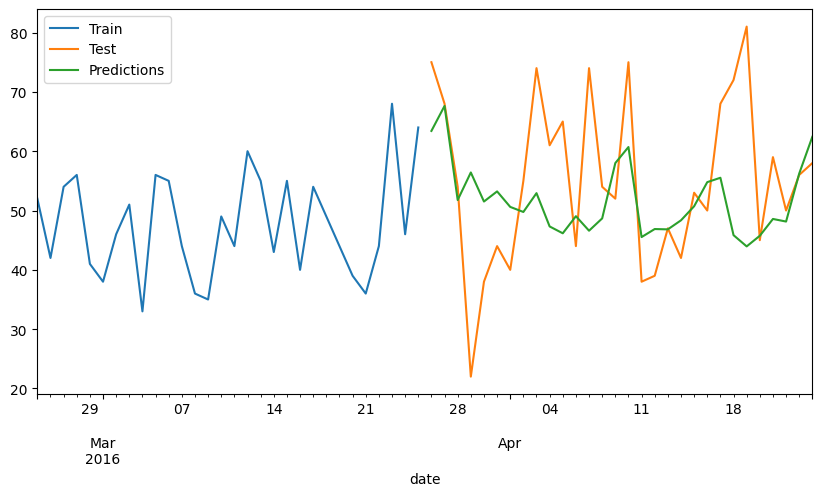

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))
y_train[-30:].plot(ax=ax, label='Train')
y_test[-30:].plot(ax=ax, label='Test')
predicciones.plot(ax=ax, label='Predictions')
ax.legend()
plt.show()